# Compare brain maps from different samplesizes

Problem: When brain maps are used for classification, the weights for the maps will be dependent on the sample size.  I.e. maps with large sample sizes will dominate the classification.

How to correct for this?
Problem is that sample size has a different effect on stationary voxels (_"null voxels"_) and voxels that are related to the design (_"active voxels"_):
- null voxels: These are under all conditions normally distributed, independent of the sample size
- active voxels: The value of these voxels increase with factor $\sqrt(n+1)/\sqrt(n)$ for each increment in samplesize

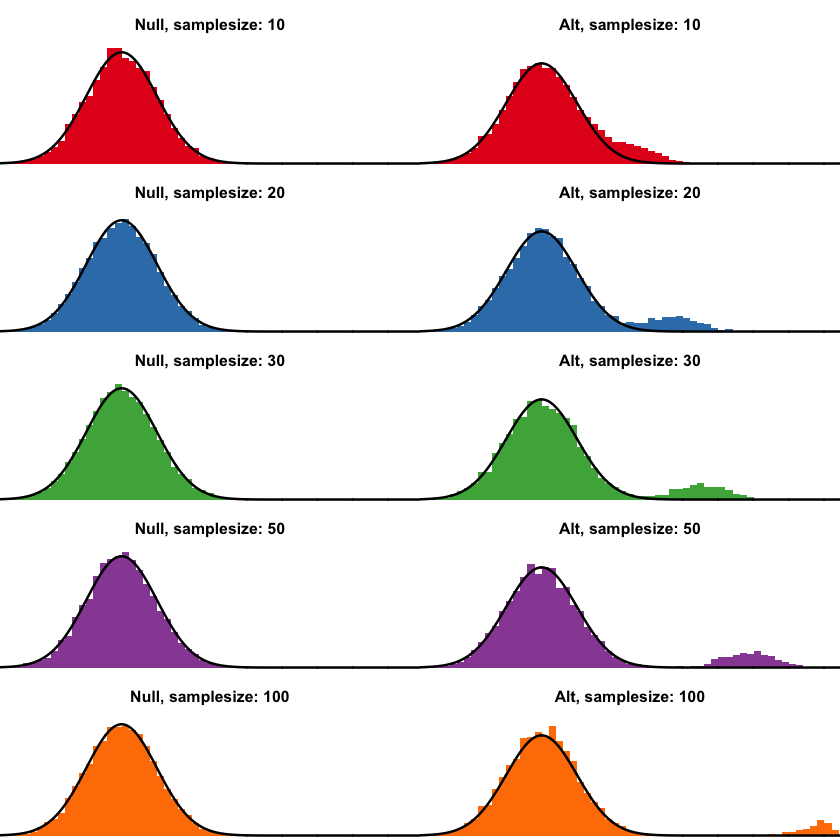

In [1]:
library(RColorBrewer)

# colors and null distribution
cols <- brewer.pal(7,"Set1")
breaks = seq(from=-10,to=10,by=0.2)
xrange <- seq(from=-10,to=10,by=0.01)
yrange <- dnorm(xrange)
sims <- 10000
# simulation
par(mfrow=c(5,2),mar=c(0,0,3,0))
for (ss in 1:5){
samplesize <- c(10,20,30,50,100)[ss]

# simulate 100 null datapoints (voxels?)
simNULL <- array(rnorm(sims*samplesize),dim=c(samplesize,sims))
mnNULL <- apply(simNULL,2,mean)
sdNULL <- apply(simNULL,2,sd)
tNULL <- mnNULL/(sdNULL/sqrt(samplesize))
zNULL <- ifelse(tNULL>0,-qnorm(1-pt(tNULL,samplesize-1)),qnorm(pt(tNULL,samplesize-1)))
hist(zNULL,col=cols[ss],border=NA,axes=FALSE,xlab="zvalue",ylab="",freq=FALSE,main=paste("Null, samplesize:",samplesize),xlim=c(-3,8),ylim=c(0,0.4),breaks=breaks)
lines(xrange,yrange,lwd=2)

# simulate 100 datapoints of which 10% is non-null
simALT <- array(rnorm(sims*samplesize),dim=c(samplesize,sims))
simALT[,(sims*0.9):sims] <- simALT[,(sims*0.9):sims]+1
mnALT <- apply(simALT,2,mean)
sdALT <- apply(simALT,2,sd)
tALT <- mnALT/(sdALT/sqrt(samplesize))
zALT <- ifelse(tALT>0,-qnorm(1-pt(tALT,samplesize-1)),qnorm(pt(tALT,samplesize-1)))
hist(zALT,col=cols[ss],border=NA,axes=FALSE,xlab="zvalue",ylab="",freq=FALSE,main=paste("Alt, samplesize:",samplesize),xlim=c(-3,8),ylim=c(0,0.4),breaks=breaks)
lines(xrange,yrange*0.9,lwd=2)
}

Figure 1: left = complete null data, right = partly non-null data (90%).  Different colors = increasing sample sizes.  Black line = standard normal distribution.  You can see that the null distribution is unaffected by sample size.  It's the non-null part that is affected.  This unequal 'affection' (?) is a problem if you want to rescale everything at once.

## SOLUTIONS

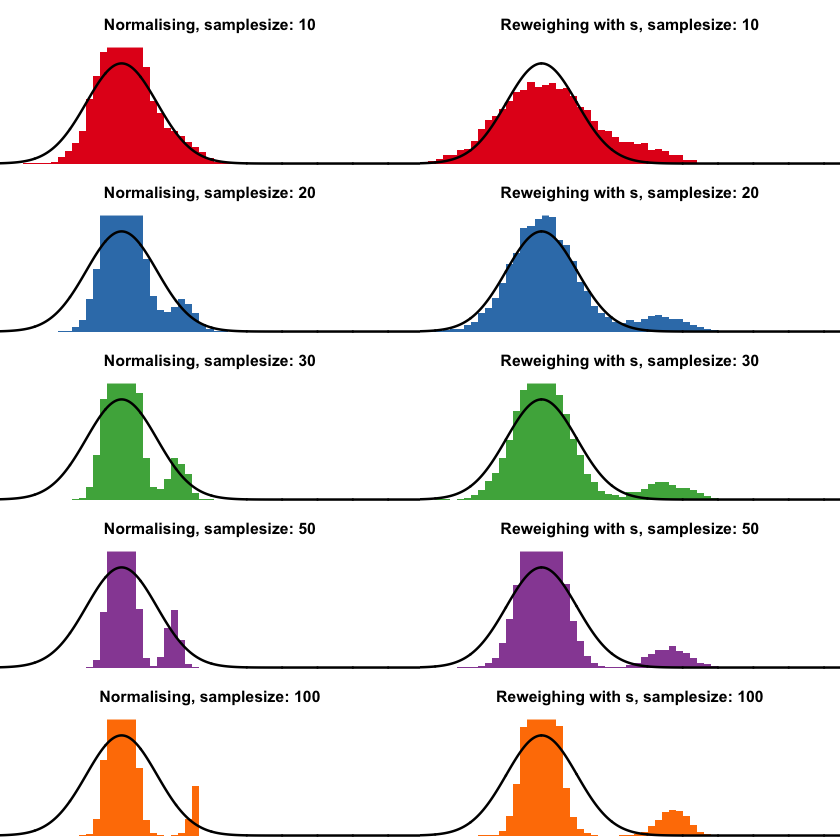

In [2]:
# simulation
par(mfrow=c(5,2),mar=c(0,0,3,0))
for (ss in 1:5){
samplesize <- c(10,20,30,50,100)[ss]

# simulate 100 datapoints of which 10% is non-null
simALT <- array(rnorm(sims*samplesize),dim=c(samplesize,sims))
simALT[,(sims*0.9):sims] <- simALT[,(sims*0.9):sims]+1
mnALT <- apply(simALT,2,mean)
sdALT <- apply(simALT,2,sd)
tALT <- mnALT/(sdALT/sqrt(samplesize))
zALT <- ifelse(tALT>0,-qnorm(1-pt(tALT,samplesize-1)),qnorm(pt(tALT,samplesize-1)))
zALT <- zALT[!zALT==Inf]
hist(zALT/var(zALT),col=cols[ss],border=NA,axes=FALSE,xlab="zvalue",ylab="",freq=FALSE,main=paste("Normalising, samplesize:",samplesize),xlim=c(-3,8),ylim=c(0,0.4),breaks=breaks)
lines(xrange,yrange*0.9,lwd=2)
    
tALTstar <- tALT*sqrt(15)/sqrt(samplesize)
zALT <- ifelse(tALTstar>0,-qnorm(1-pt(tALTstar,samplesize-1)),qnorm(pt(tALTstar,samplesize-1)))
hist(zALT,col=cols[ss],border=NA,axes=FALSE,xlab="zvalue",ylab="",freq=FALSE,main=paste("Reweighing with s, samplesize:",samplesize),xlim=c(-3,8),ylim=c(0,0.4),breaks=breaks)
lines(xrange,yrange*0.9,lwd=2)
    
}

Figure 2: left = normalised variance, right = reweighted with factor $c=\sqrt{n_{fixed}}/\sqrt{n_{map}}$ such that all values are rescaled to a fixed n (here: 15).  Normalised variance is problematic. Rescaling with factor $c$ correctly rescales the important information in the maps (the non-null part), but also affects the null distribution. *THE* question: is this a bad thing?